# X-ray absorption spectroscopy simulation in the time domain 

What will be the first quantum algorithm that is industrially useful to run on a fault-tolerant quantum computer? This open question is one of the main focuses of the research team at Xanadu. A potential answer to this question is simulating [X-ray absorption spectroscopy](https://en.wikipedia.org/wiki/X-ray_absorption_spectroscopy), which can be used in workflows to identify structural degradation mechanisms in material candidates for battery designs 🔋. This demo will show you how to implement an optimized version of a simulation algorithm developed in the paper ["Fast simulations of X-ray absorption spectroscopy for battery materials on a quantum computer"](https://arxiv.org/abs/2506.15784) [#Fomichev2025]_ in PennyLane. 

First, we will discuss why simulating X-ray absorption spectroscopy is a promising application for early quantum computers. Then we will explain the main steps in the simulation algorithm, and how to implement a simplified version in PennyLane.

We will be using concepts that were introduced in other PennyLane demos, such as [Using PennyLane with PySCF and OpenFermion](https://pennylane.ai/qml/demos/tutorial_qchem_external), [Initial state preparation for quantum chemistry](https://pennylane.ai/qml/demos/tutorial_initial_state_preparation), and [How to build compressed double-factorized Hamiltonians](https://pennylane.ai/qml/demos/tutorial_how_to_build_compressed_double_factorized_hamiltonians). If you haven't checked out those demos yet, it might be best to do so and then come back here 🔙.

## Why simulate X-ray absorption spectroscopy?
Lithium-excess materials are transition metal oxides that have been engineered to accommodate extra Lithium atoms in their structural composition, designed as a candidate for use in battery cathodes. However, repeated charge-discharge cycles can alter the structure and reduce performance. One can study these degraded materials using X-ray absorption spectroscopy, which directly probes local structure by exciting tightly bound core electrons. This can be used to identify oxidation states in materials, because different elements and their oxidation states will absorb photons of different energies. However, identification requires reference spectra for each expected degradation outcome in order to determine the composition of structures present in the material. We call this "spectral fingerprinting", where the observed spectrum can be matched to combinations of spectra from small clusters. A fast method of simulating reference spectra for use in fingerprinting would be a crucial component of a workflow for identifying promising cathode materials.

![alt text](../_static/demonstration_assets/xas/fingerprinting.gif)

Figure X: *How simulation of X-ray absorption spectra can enable identification of oxidation states in candidate battery materials.* Spectral fingerprinting can be used to identify constituent structures of a material by decomposing experimental spectra into components calculated via simulation on a quantum computer.

Simulating these spectra is a difficult task for classical computers -- the highly correlated excited states are difficult to compute classically, particularly for transition metals. However, the relatively small set of electronic orbitals needed to simulate these small clusters make this simulation task well suited for early quantum computers, which can naturally handle the high correlation between orbitals, but may be limited in their number of qubits.

## Algorithm
Simulating reference spectra requires calculating the observable of the experiment, which in this case is the [*absorption cross section*](https://en.wikipedia.org/wiki/Absorption_cross_section). We will describe this quantity below, and then explain how a *time-domain* simulation algorithm can estimate it.

### Absorption cross-section
In XAS experiments the absorption cross section as a function of the frequency of incident X-rays $\sigma_A(\omega)$ is measured for a given material. This is related to the rate of absorption of X-ray photons of various energies. For our situation, the electrons in the molecular cluster start in a ground molecular state $|I\rangle$ with energy $E_I$, and will be coupled to an excited state $|F\rangle$ with energy $E_F$ through the action of the dipole operator $\hat m_\rho$, which represents the effect of the radiative field, where $\rho$ is any of the Cartesian directions $\{x,y,z\}$. 

The absorption cross section is given by

$$ \sigma_A(\omega) = \frac{4 \pi}{3 \hbar c} \omega \sum_{F \neq I}\sum_{\rho=x,y,z} \frac{|\langle F|\hat m_\rho|I \rangle|^2 \eta}{((E_F - E_I)-\omega)^2 + \eta^2}\,, $$

where $c$ is the speed of light, $\hbar$ is Plank's constant, and $\eta$ is the line broadening which here is set by the experimental resolution of the spectroscopy, and is typically around $1$ eV. Below is an illustration of an XAS spectra. In the illustration, there appear to be five excited states coupled by the X-rays, each with varying amounts of overlap with the inital state.

![alt text](../_static/demonstration_assets/xas/example_spectrum.png){ width=50% }

Figure X: *Example X-ray absorption spectrum.* Illustration of how the peak positions $E_F - E_i$, widths $\eta$ and amplitudes $|\langle F | \hat m_\rho | I \rangle|^2$ determine the spectrum.

The goal is to implement a quantum algorithm that can calculate this spectrum. However, instead of computing the energy differences and state overlaps directly, we will be simulating the system in the time domain, and then using a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) to obtain the frequency spectrum.

### Quantum algorithm in the time-domain
Both the initial state $|I\rangle$ and the dipole operator acting on the initial state $\hat m_\rho|I\rangle$ can be determined classically, and we'll demonstate how to do that later. Given the initial state, we will use a mathematical trick called a *frequency-domain* [Green's function](https://en.wikipedia.org/wiki/Green%27s_function) to determine the absorption cross section. We can write the cross section as the imaginary part of the following Green's function

$$\mathcal{G}_\rho(\omega) = \langle I|\hat m_\rho \frac{1}{\hat H -E_I -\omega +i\eta} \hat m_\rho |I\rangle\,.$$

Using a resolution of identity of the final states and simplifying, we end up with

$$ \mathrm{Im}(\mathcal{G_\rho(\omega)}) = -\sum_{F\neq I} \frac{|\langle F|\hat m_\rho|I\rangle|^2\eta}{(E_F- E_I -\omega)^2 +\eta^2} - \frac{|\langle I|\hat m_\rho|I\rangle|^2\eta}{\omega^2 +\eta^2}\,, $$

where the first term is clearly proportional to the absorption cross section. The second term is zero if we centre the frame of reference for our molecular orbitals at the nuclear-charge weighted centre for our molecular cluster of choice. Okay, so how to we determine $\mathcal{G_\rho(\omega)}$? If we are going to evaluate this quantity in a quantum register, it will need to be normalized, so instead we are looking for

$$ G_\rho(\omega) = \eta \frac{\mathcal{G}_\rho(\omega)}{||\hat m_\rho | I \rangle ||^2} \,. $$

There are methods for determining this frequency-domain Green's function directly [#Fomichev2024]_, however, our algorithm will aim to estimate the discrete-time *time-domain* Green's function $\tilde G(t_j)$ at times $t_j$ where $j$ is the time-step index. $G_\rho(\omega)$ can then be calculated classically through the time-domain Fourier transform

$$ -\mathrm{Im}\,G_\rho(\omega) = \frac{\eta\tau}{2\pi} \sum_{j=-\infty}^\infty e^{-\eta |t_j|} \tilde G(t_j) e^{i\omega t_j}\,, $$

where $\tau \sim \mathcal{O}(||\hat H||^{-1})$ is the size of the time step, which should be small enough to resolve the largest frequency components that we are interested in, which correspond to the final states with the largest energy. In practice, this is not the largest eigenvalue of $\hat H$, but simply the largest energy we want to show in the spectrum.

Now, where this all comes together is that the time-domain Green's function can be determined using the expectation value of the time-evolution operator (normalized)

$$ \tilde G_\rho(t_j) = \frac{\langle I|\hat m _\rho e^{- i\hat H t_j} \hat m_\rho |I\rangle}{|| \hat m_\rho |I\rangle ||^2}\,, $$

and this is something that can be easily done on a quantum computer! We can use a [Hadamard test](https://en.wikipedia.org/wiki/Hadamard_test) on the time evolution unitary to measure the expectation value for each time $t_j$. We will repeat this test a number of times $N$ and take the mean of the results to get an estimate for $G_\rho(t_j)$, which we can Fourier transform to get the spectrum. 

The circuit we will construct to determine the expectation values is shown below. It has three main components: *state prep*, the state $\hat m_\rho |I\rangle$ is prepared in the quantum register, and an auxiliary qubit is prepared for controlled time evolution; *time evolution*, the state is evolved under the electronic Hamiltonian; *measurement*, the time-evolved state is measured to obtain statistics for the expectation value.

![alt text](../_static/demonstration_assets/xas/global_circuit.png) 

Figure X: *Circuit for XAS simulation*. The algorithm is ultimately a Hadamard test circuit, and we divide the steps of this into three components. 

Let's look at how to implement these steps in PennyLane. We will make extensive use of the `qml.qchem` module, as well as modules from [PySCF](https://pyscf.org/). For this demo, we are going to use the simple $H_2$ molecule. We will implement some, but not all of the optimizations detailed in [#Fomichev2025]_. The other optimizations will be discussed at the end.

## State preparation
We need to classically determine the ground state $|I\rangle$, and the dipole operator's action on that state.

### Ground state calculation
If you haven't, check out the demo ["Initial state preparation for quantum chemistry"](https://pennylane.ai/qml/demos/tutorial_initial_state_preparation). We will be expanding on this demo by writing code to import a state from the [multiconfigurational self-consistent field](https://pyscf.org/user/mcscf.html) (MCSCF) methods of PySCF, where we restrict the set of active orbitals used in the calculation. Using only a subset of orbitals known as the "active space" reduces the cost of performing calculations on complicated molecular instances, while hopefully still preserving the interesting features of the molecule. The `CASCI` method in PySCF is equivalent to a full-configuration interaction (FCI) procedure on a subset of molecular orbitals.

We start by creating our molecule object using the [Gaussian type orbitals](https://en.wikipedia.org/wiki/Gaussian_orbital) module `pyscf.gto`, and obtaining the reduced Hartree-Fock molecular orbitals with the [self-consistent field methods](https://pyscf.org/user/scf.html) `pyscf.scf`.

In [41]:
from pyscf import gto, scf
import numpy as np

# Create a Mole object.
r = 0.71  # Bond length in Angstrom.
symbols = ["H", "H"]
geometry = np.array([[0.0, 0.0, -r/2], [0.0, 0.0, r/2]])
basis = "631g"
mol = gto.Mole(atom=zip(symbols, geometry), basis=basis, symmetry=None)
mol.build(verbose=0)

# Get the molecular orbitals.
hf = scf.RHF(mol)
hf.run(verbose=0)

To make sure that $\langle I|\hat m_\rho|I\rangle$ is zero, we can shift the `Mole` object's coordinates such that the nuclear-charge-weighted centre is at the origin. Note this is true from our construction, since the geometry was defined to be symmetric about the origin, but I want to emphasize the importance of this condition.

In [42]:
# Guarantee nuclear charge centre is at the origin.
charges, coords = (hf.mol.atom_charges(), hf.mol.atom_coords())
nuc_charge_center = np.einsum("z,zx->x", charges, coords) / charges.sum()
print("Initial nuclear charge centre", nuc_charge_center)
hf.mol.set_common_orig_(nuc_charge_center)
print("Shifted nuclear charge centre", nuc_charge_center)

Initial nuclear charge centre [0. 0. 0.]
Shifted nuclear charge centre [0. 0. 0.]


Great, the nuclear-weighted charge centre is at the origin. 

Since we will be using PennyLane for other aspects of this calculation, we want to make sure the molecular orbital coefficients are consistent between our PennyLane and PySCF calculations. To do this, we can obtain the molecular orbital coefficients from PennyLane using the `hartree_fock.scf` method of `qchem`, and change the coefficients in the `hf` instance to match.

In [43]:
import pennylane as qml

# Create qml Molecule object.
mole = qml.qchem.Molecule(symbols, geometry, basis_name='6-31g', unit='angstrom')

# Run self-consistent fields method to get MO coefficients.
_, coeffs, _, _, _ = qml.qchem.hartree_fock.scf(mole)()

hf.mo_coeff = coeffs  # Change MO coefficients in hf object to PennyLane calculated values.

Next, let's define the active space of orbitals we will use for our calculation. For $H_2$, we can just use the full space of orbitals. We will use a `CASCI` instance to calculate the ground state of our system with this selected active space. 

In [44]:
from pyscf import mcscf

# Define active space.
ncas, nelecas = (4, 2)
ncore = (mol.nelectron - nelecas) // 2

# Initialize CASCI instance of H2 molecule
mycasci = mcscf.CASCI(hf, ncas=ncas, nelecas=nelecas)
mycasci.run(verbose=0)

# Calculate ground state, and omit small state components.
cascivec = mycasci.ci
cascivec[abs(cascivec) < 1e-6] = 0

To implement this state as a PennyLane statevector, we need to convert the `cascivec` into a format that is easy to import into PennyLane. One way to do this is to use a sparse matrix representation to turn `cascivec` into a dictionary, and then use `qml.qchem.convert.import_state` to import into PennyLane. Here is how you can go about turning a full-configuration interaction matrix into a dictionary.

In [45]:
from scipy.sparse import coo_matrix
from pyscf.fci.cistring import addrs2str

# Convert cascivec into a sparse matrix.
sparse_cascimatr = coo_matrix(cascivec, shape=np.shape(mycasci.ci), \
                                                    dtype=float )
row, col, dat = sparse_cascimatr.row, sparse_cascimatr.col, \
                                                sparse_cascimatr.data

# Turn indices into strings.
ncas_a = mycasci.ncas
ncas_b = ncas_a
nelecas_a, nelecas_b = mycasci.nelecas
strs_row = addrs2str(ncas_a, nelecas_a, row)
strs_col = addrs2str(ncas_b, nelecas_b, col)

# Create the FCI matrix as a dict.
wf_casci_dict = dict(zip(list(zip(strs_row, strs_col)), dat))

Lastly, we will use the helper function `_sign_chem_to_phys` to adjust the sign of state components to match what they should be for the PennyLane orbital occupation number ordering. Then, we can import the state to PennyLane using `_wf_dict_to_statevector`.

In [46]:
from pennylane.qchem.convert import _sign_chem_to_phys, _wfdict_to_statevector

# Convert to physicist's notation.
wf_casci_dict = _sign_chem_to_phys(wf_casci_dict, ncas)

wf_casci = _wfdict_to_statevector(wf_casci_dict, ncas) # This is |I>.

### Dipole operator action
The electromagnetic field of the X-rays couples electronic states through the [dipole operator](https://en.wikipedia.org/wiki/Transition_dipole_moment). The action of this operator is implemented in PennyLane as `qml.qchem.dipole_moment`. We can calculate that operator, convert it to a matrix, and apply it to our initial state $|I\rangle$ to obtain $m_\rho|I\rangle$. 

To generate this operator, we have to specify which molecular orbitals are in our active space. We can obtain the indices of the included and excluded orbitals using `qml.qchem.active_space` to obtain the lists active and core, respectively.

The action of the dipole operator will be split into the three cartesian directions $\{x, y, z\}$, which we will loop over to obtain the states $m_{\{x,y,z\}}|I\rangle$.

In [47]:
# Solve for active space.
core, active = qml.qchem.active_space(mole.n_electrons, mole.n_orbitals,
                        active_electrons=nelecas, active_orbitals=ncas)

m_rho = qml.qchem.dipole_moment(mole, cutoff=1e-8, core=core, active=active)()
rhos = range(len(m_rho))  # [0, 1, 2] are [x, y, z].

wf_dipole = []
dipole_norm = []

# Loop over cartesian coordinates and calculate m_rho|I>.
for rho in rhos:
    dipole_matrix_rho = qml.matrix(m_rho[rho], wire_order=range(2*ncas))
    wf = dipole_matrix_rho.dot(wf_casci)

    if np.allclose(wf, np.zeros_like(wf)):
        wf_dipole.append(wf)
        dipole_norm.append(0)
        
    else:
        # Normalize the wavefunction.
        dipole_norm.append(np.linalg.norm(wf))
        wf_dipole.append(wf/dipole_norm[rho])

Note when converting the operator to a matrix, the full set of wires need to be specified, otherwise the matrix will not have the right dimension. Our full space is two times the number of orbitals, since we need to account for spin.

Let's prepare the circuit that will initialize our qubit register with this state. We will need $2 n_\mathrm{cas}$ wires as mentioned above and one auxiliary wire for the measurement circuit, which we will prepare as the 0 wire with an applied Hadamard gate.

In [48]:
import pennylane as qml

device_type = "lightning.qubit"

# Initialization circuit for m_rho|I>.
dev_prop = qml.device(device_type, wires=int(2*ncas) + 1, shots=None)

@qml.qnode(dev_prop)
def initial_circuit(wf):
    # Dipole wavefunction preparation.
    qml.StatePrep(wf, wires=dev_prop.wires.tolist()[1:])
    qml.Hadamard(wires=0)
    return qml.state()

## Time Evolution
Next we will discuss how to prepare the electronic Hamiltonian for use in the time-evolution of the Hadamard-test circuit. This constitutes the main body of our simulation circuit and includes most of the optimizations in the algorithm.

### Electronic Hamiltonian
Our electronic Hamiltonian is

$$ H = E + \sum_{p,q=1}^N \sum_{\gamma\in\{\uparrow,\downarrow\}} (p|\kappa|q) a^\dagger_{p\gamma}a_{q\gamma} + \frac12 \sum_{p,q,r,s=1}^N\sum_{\gamma,\beta\in\{\uparrow,\downarrow\}} (pq|rs) a^\dagger_{p\gamma}a_{q\gamma} a^\dagger_{r\beta}a_{s\beta} \,, $$

where $a^{(\dagger)}_{p\gamma}$ is the annihilation (creation) operator for a molecular orbital $p$ and spin $\gamma$, $E$ is the core constant, $N$ is the number of spatial orbitals, and $(p|\kappa|q)$ and $(pq|rs)$ are the one- and two-electron integrals, respectively [#Cohn2021]_. 

The core constant and the one- and two-electron integrals can be computed in PennyLane using functions from `qml.qchem.hartree_fock`.

In [49]:
# Calculate electron integrals.
core_constant, one, two = qml.qchem.electron_integrals(mole, core=core, active=active)()
core_constant = core_constant[0]

We will have to convert these to chemist's notation [#Sherrill2005]_.

In [50]:
# To chemist notation.
two_chemist = np.einsum('prsq->pqrs', two)
one_chemist = one - np.einsum('pqrr->pq', two)/2.

If you haven't yet, go read the demo ["How to build compressed double-factorized Hamiltonians"](https://pennylane.ai/qml/demos/tutorial_how_to_build_compressed_double_factorized_hamiltonians), because that is exactly what we are going to do! A compressed double-factorized Hamiltonian takes on the form [#Cohn2021]_ [#Yen2021]_

$$ H_\mathrm{CDF} = E + \sum_{\gamma\in\{\uparrow,\downarrow\}} U_\gamma^{(0)} \left(\sum_p Z_p^{(0)} a_{\gamma,p}^\dagger a_{\gamma, p}\right) U_\mathrm{\gamma}^{(0)\,\dagger} + \sum_\ell^L \sum_{\gamma,\beta\in\{\uparrow,\downarrow\}} U_\mathrm{\gamma, \beta}^{(\ell)} \left( \sum_{pq} Z_{pq}^{(\ell)} a_{\gamma, p}^\dagger a_{\gamma, p} a_{\beta,q}^\dagger a_{\beta, q}\right) U_{\gamma, \beta}^{(\ell)\,\dagger} \,, $$

where each one-electron integral is approximated by a matrix $Z^{(0)}$ surrounded by single-particle rotation matrices $U^{(0)}$ which diagonalize $Z^{(0)}$. Each two-electron integral is approximated by a sum of $L$ of these rotation and diagonal matrix terms, indexed as $(\ell)$. The number of factors $L$ affects the accuracy of the approximation.

We can compress and double-factorize the two-electron integrals using `qml`'s `qchem.factorize` function, with `compressed=True`. We will set $L$ as the number of orbitals in our active space. The `Z` and `U` output here will have shapes with dimensions $(L, n_\mathrm{cas}, n_\mathrm{cas})$, i.e. they are arrays of $L$ fragment matrices with dimension $n_\mathrm{cas} \times n_\mathrm{cas}$.

In [51]:
# Factorize hamiltonian, producing matrices.
L = ncas  # Usually L is on the order of ncas.
_, Z, U = qml.qchem.factorize(two_chemist, compressed=True, num_factors=L)

print("Shape of the factors: ")
print("two_chemist", two_chemist.shape)
print("U", U.shape)
print("Z", Z.shape)

# Compare factorized two-electron terms to the originals.
approx_two_chemist = qml.math.einsum("tpk,tqk,tkl,trl,tsl->pqrs", U, U, Z, U, U)
assert qml.math.allclose(approx_two_chemist, two_chemist, atol=1e-2)

Shape of the factors: 
two_chemist (4, 4, 4, 4)
U (4, 4, 4)
Z (4, 4, 4)


Note there are some terms in this decomposition that are exactly diagonalizable, and can be added to the one-electron terms to simplify the simulation. We call these the "one-electron extra" terms and add them to the one-electron integrals, using `np.linalg.eigh` to diagonalize them into the matrix $Z^{(0)}$ with the rotation matrix $U^{(0)}$.

In [52]:
# Calculate the one-electron extra.
Z_prime = np.stack([np.diag(np.sum(Z[i], axis=-1)) for i in range(Z.shape[0])], axis=0)
one_electron_extra = np.einsum('tpk,tkk,tqk->pq', U, Z_prime, U)

# Diagonalize the one-electron integral matrix while adding the one-electron extra.
eigenvals, U0 = np.linalg.eigh(one_chemist + one_electron_extra)
Z0 = np.diag(eigenvals)

### Constructing the time-propagation circuit
The main work of our algorithm will be to apply our Hamiltonian terms as a trotter product in a time-evolution operator, and measure the expectation value of that time evolution for various times. Let's start by writing functions that implement the time evolution for each Hamiltonian term, which will be called by our trotter circuit. One thing to track throughout this implementation is the global phase accrued throughout the time evolution. For a derivation of the global phase for the two-electron terms, see Appendix A in [#Fomichev2025]_.

The trick when implementing a double-factorized Hamiltonian is to use [Thouless's theorem](https://joshuagoings.com/assets/Thouless_theorem.pdf) [#Thouless1960]_ to apply the single-particle basis rotations $U^{(\ell)}$, and then the Jordan-Wigner transform to implement the number operators $a^\dagger_p a_p$ as Pauli-Z rotations. Below is an illustration of the circuit we will use to implement the one- and two-eletron terms in our factorized Hamiltonian. 

![alt text](../_static/demonstration_assets/xas/UZU_circuits.png){ width=80% }

Figure X: One- and two-electron term implementations in time-evolution circuit (ignoring global phases).

We can use `qml.BasisRotation` to generate a [Givens decomposition](https://pennylane.ai/qml/demos/tutorial_givens_rotations) for the single-body basis rotation determined by $U^{(\ell)}$. We will have to do this for both spin-halves of the register.

In [53]:
def U_rotations(U, control_wires):
    """Circuit implementing the basis rotations of the CDF decomposition."""
    U_spin = qml.math.kron(U, qml.math.eye(2))  # Apply to both spins.
    qml.BasisRotation(unitary_matrix=U_spin, wires=[int(i + control_wires) for i in range(2*ncas)])

Next we write a function to perform the $Z$ rotations. Controlled arbitrary-angle rotations are expensive. To reduce the cost of having to implement many controlled Z rotations at angles determined by the matrices $Z^{(\ell)}$, we instead implement *uncontrolled* Z rotations sandwiched by CNOT gates. 

![alt text](../_static/demonstration_assets/xas/double_phase_trick.png) 

Figure X: Double-phase trick to decompose expensive controlled-Z rotations into an uncontrolled-Z rotation sandwiched by CNOT gates.

For the one-electron terms, we loop over spin and orbital index, and apply the Z rotations using this double-phase trick. The two-electron terms are implemented the same way, except the two-qubit rotations use `qml.MultiRZ`.

In [54]:
from itertools import product

def Z_rotations(Z, step, is_one_electron_term, control_wires):
    """Circuit implementing the Z rotations of the CDF decomposition."""
    if is_one_electron_term:
        for sigma in range(2):
            for i in range(ncas):
                qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)),
                                    control=range(control_wires), control_values=0)
                qml.RZ(-Z[i, i] * step/2, wires=int(2*i + sigma + control_wires))
                qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)),
                                    control=range(control_wires), control_values=0)
        globalphase = np.sum(Z) * step

    else:  # It's a two-electron term.
        for sigma, tau in product(range(2), repeat=2):
            for i, k in product(range(ncas), repeat=2):
                if (i != k or sigma != tau):  # Skip the one-electron correction terms.
                    qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)), 
                            control = range(control_wires), control_values=0)
                    qml.MultiRZ(Z[i, k]/8.*step, 
                            wires=[int(2*i + sigma + control_wires), int(2*k + tau + control_wires)])
                    qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)),
                            control = range(control_wires), control_values=0)
        globalphase = np.trace(Z)/4.*step - np.sum(Z)*step + np.sum(Z)*step/2.

    qml.PhaseShift(-globalphase, wires = 0)

Now that we have functions for the complicated terms of our Hamiltonian, we can define our Trotter step. The function will implement the $U$ rotations and $Z$ rotations, and adjust the total phase from the core constant term. By tracking the last $U$ rotation used, we can implement two consecutive rotations at once as $V^{(\ell)} = U^{(\ell-1)}(U^{(\ell)})^T$, halving the number of rotations required per Trotter step. 

Below, we define a function `LieTrotter` which applies the rotations for the one- and two-electron terms in one order, but can also reverse the order. This can save another rotation step when we implement consecutive Trotter steps in higher-order Trotter schemes. At the end of the step, the core constant adjusts a global phase.

In [55]:
def LieTrotter(step, prior_U, final_rotation, reverse=False):
    """Implements a first-order Trotterized circuit for the CDF."""
    # Combine the one- and two-electron matrices.
    _U0 = np.expand_dims(U0, axis=0)
    _Z0 = np.expand_dims(Z0, axis=0)
    _U = np.concatenate((_U0, U), axis=0)
    _Z = np.concatenate((_Z0, Z), axis=0)

    num_two_electron_terms = U.shape[0]  # Number of fragments \ell.
    is_one_body = np.array([True] + [False] * num_two_electron_terms)
    order = list(range(len(_Z)))

    if reverse: 
        order = order[::-1]

    for term in order:
        U_rotations(prior_U @ _U[term], 1)
        Z_rotations(_Z[term], step, is_one_body[term], 1)
        prior_U = _U[term].T

    if final_rotation: 
        U_rotations(prior_U, 1)

    # Global phase adjustment from core constant.
    qml.PhaseShift(-core_constant * step, wires=0)

    return prior_U

Our function `trotter_circuit` implements a second-order Trotter step, returning a `QNode`. The returned circuit applies `StatePrep` to prepare the register in the previous quantum state, and then two `LieTrotter` evolutions for time `step/2` so that the total step size is `step`.

In [56]:
def trotter_circuit(dev, state, step):
    """Implements a second-order Trotterized circuit for the CDF."""
    qubits = dev.wires.tolist()

    def circuit():
        # State preparation -- set as previous iteration final state.
        qml.StatePrep(state, wires=qubits)

        # Main body of the circuit.
        prior_U = np.eye(ncas)  # No initial prior U, so set as identity matrix.
        prior_U = LieTrotter(step / 2, prior_U=prior_U, final_rotation=False, reverse=False)
        prior_U = LieTrotter(step / 2, prior_U=prior_U, final_rotation=True, reverse=True)

        return qml.state()

    return qml.QNode(circuit, dev)

## Measurement

To measure the expectation value of the time-propagated state, we use a Hadamard test circuit. This uses `qml.StatePrep` to set the state as it was returned by the time evolution, and then measures both the real and imaginary expectation values using `PauliX` and `PauliY`, respectively.

In [57]:
def meas_circuit(state):
    qml.StatePrep(state, wires=range(int(2*ncas)+1))
    # Measure in PauliX/PauliY to get the real/imaginary parts.
    return [qml.expval(op) for op in [qml.PauliX(wires=0), qml.PauliY(wires=0)]]

Note we can only obtain both real and imaginary expectation values in the simulated circuit. An actual implementation would have to select real or imaginary by inserting a phase gate, like in the circuit below. 

![alt text](../_static/demonstration_assets/xas/hadamard_test_circuit.png){ width=70% }

Figure X: *Hadamard test circuit to measure expectation value of time-evolution operator*. With the phase gate $S^\dagger$ present (absent), this gives the real (imaginary) part of the time-domain Green's function $\tilde G(\tau j)$.

## Run Simulation
Let's define the simulation parameters we're are going to use. This includes:
 - The Lorentzian width $\eta$ of the spectrum peaks, representing the experimental resolution. 
 - The time step $\tau$, which should be small enough to resolve the largest frequency components we want to determine. 
 - The maximum number of time steps $j_\mathrm{max}$, which sets the largest evolution time. This should be large enough so that we can distinguish between the small frequency components in our spectrum.
 - The total number of shots we will use to obtain statistics for the expectation value after the time evolution.

In [58]:
eta = 0.05  # In Hartree energy units (Ha).
H_norm = 1.5  # Maximum final state eigenvalue used to determine tau.
tau = np.pi / (2 * H_norm)  # Time step, set by largest relevant eigenvalue.
jmax = 40  # Max number of time steps.
total_shots = 500 * 2 * jmax  # Total number of shots for expectation value statistics.

jrange = np.arange(1, 2 * int(jmax) + 1, 1)
time_interval = tau * jrange

Minimizing the number of shots we require to obtain the necessary expectation value statistics will improve the efficiency of our algorithm. One way to do this is to employ a sampling distribution that takes advantage of the decaying Lorentzian kernel, exponentially reducing the shot allocation for longer evolution times [#Fomichev2025]_. This is implemented below by creating `shots_list`, which distributes the `total_shots` among the time steps, weighted by the Lorentzian kernel. The parameter $\alpha$ can adjust this weighting, s.t. for $\alpha > 1$ there is more weight at shorter times.

In [59]:
def L_j(t_j):
    """Time-dependent shot distribution."""
    return np.exp(-eta*t_j)


alpha = 1.1  # Tunable kernel weighting.
A = np.sum([L_j(alpha*t_j) for t_j in time_interval])  # Normalization factor so total shots is as defined.

# Kernel-aware list of shots for each time step.
shots_list = [int(round(total_shots * L_j(alpha*t_j) / A)) for t_j in time_interval]

Finally, we can run the simulation to determine the expectation values at each time step, which are related to the time-domain Green's function.

In [60]:
expvals = np.zeros((2, len(time_interval)))  # Results list initialization.

# Loop over cartesian coordinate directions.
for rho in rhos:

    if dipole_norm[rho] == 0:  # Skip if no excited states coupled.
        continue 

    # Initialize state m_rho|I> (including the auxiliary qubit).
    state = initial_circuit(wf_dipole[rho])

    # Perform time steps.
    for i in range(0, len(time_interval)):

        circuit = trotter_circuit(dev=dev_prop, state=state, step=tau)

        # Define measurement circuit device with shots.
        shots = shots_list[i]  # Kernel-aware number of shots.
        dev_est = qml.device(device_type, wires=int(2 * ncas) + 1, shots=shots)

        # Update state and then measure expectation values.
        state = circuit()
        measurement = qml.QNode(meas_circuit, dev_est)(state)
        
        expvals[:, i] += dipole_norm[rho]**2 * np.array(measurement).real

Plotting the time-domain output, we see there is one clear frequency, so we will expect one peak in our spectrum.

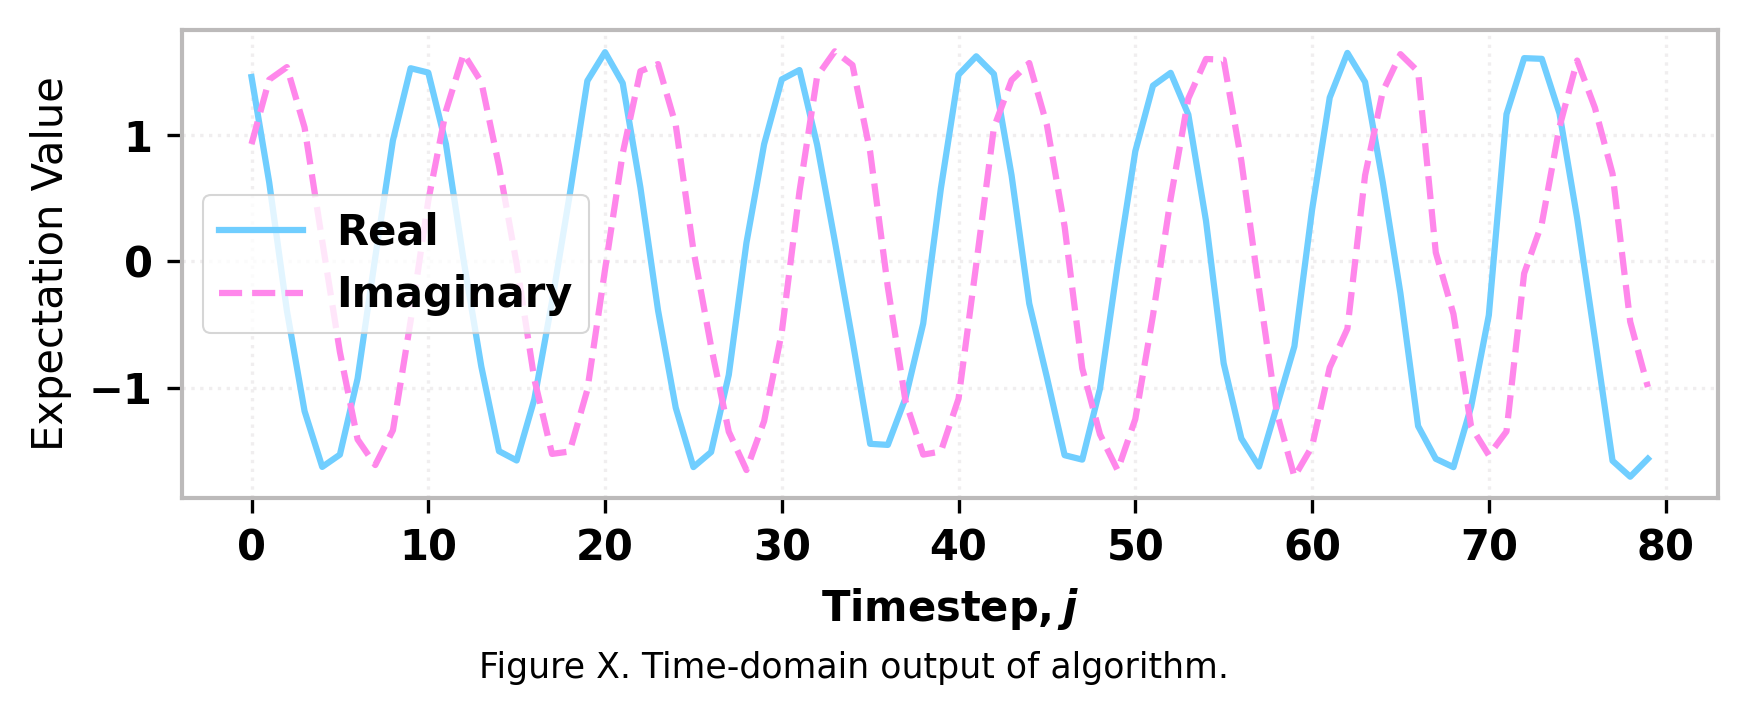

In [61]:
import matplotlib.pyplot as plt
plt.style.use("pennylane.drawer.plot")

fig = plt.figure(figsize=(6.4, 2.4))
ax = fig.add_axes((0.15, 0.3, 0.8, 0.65))  # Leave space for caption.
ax.plot(range(len(expvals[0, :])), expvals[0, :], label="Real")
ax.plot(range(len(expvals[1, :])), expvals[1, :], label="Imaginary", linestyle="--")
ax.set(xlabel=r"$\mathrm{Time step}, j$", ylabel=r"Expectation Value")
fig.text(0.5, 0.05, "Figure X. Time-domain output of algorithm.",
    horizontalalignment="center", size="small", weight="normal")
ax.legend()
plt.show()

Since the real and imaginary components of the time-domain Green's function are determined seperately, we can calculate the Fourier transform like

$$ -\mathrm{Im}\,G_\rho(\omega) = \frac{\eta\tau}{2\pi}\left(1 + 2\sum_{j=1}^{j_\mathrm{max}}\left[ \mathbb{E}\left(\mathrm{Re}\,\tilde G(\tau j)\right)\mathrm{cos}(\tau j \omega) - \mathbb{E}\left(\mathrm{Im}\,\tilde G(\tau j)\right) \mathrm{sin}(\tau j \omega)\right]\right) \,,$$

where $\mathbb{E}$ is the expectation value. We do this below, but also multiply the normalization factors over to the right side. 

In [62]:
L_js = L_j(time_interval)

f_domain_Greens_func = lambda w: tau/(2*np.pi) * (np.sum(np.array(dipole_norm)**2)\
     + 2*np.sum(L_js * (expvals[0,:] * np.cos(time_interval * w)   
                - expvals[1,:] * np.sin(time_interval * w))))

wgrid = np.linspace(-2, 5, 10000)  # Frequency array for plotting.
w_min, w_step = wgrid[0], wgrid[1] - wgrid[0]

spectrum = np.array([f_domain_Greens_func(w) for w in wgrid])

Since our active space for $H_2$ is small, we can easily calculate a classical spectrum for comparison. We do this using the `mycasci` instance that we used to determine the ground state, but instead solve for more states by increasing the number of roots in the `fcisolver`.  We can also calculate the transition density matrix in the molecular orbital basis, $\langle F| \hat m_\rho |I \rangle$.

In [63]:
# Use CASCI to solve for excited states.
mycasci.fcisolver.nroots = 100  # Compute the first 10 states.
mycasci.run(verbose=0)
mycasci.e_tot = np.atleast_1d(mycasci.e_tot)

# Determine the dipole integrals using atomic orbitals from RHF object.
dip_ints_ao = hf.mol.intor('int1e_r_cart', comp=3) # In atomic orbital basis.
mo_coeffs = coeffs[:,ncore:ncore+ncas]

# Convert to molecular orbital basis.
dip_ints_mo = np.einsum('ik,xkl,lj->xij', mo_coeffs.T, dip_ints_ao, mo_coeffs)


def makedip(ci_id):
    # Transition density matrix in molecular orbital basis.
    t_dm1 = mycasci.fcisolver.trans_rdm1(mycasci.ci[0], mycasci.ci[ci_id], 
                                            ncas, nelecas)
    # Transition dipole moments.
    return np.einsum('xij,ji->x', dip_ints_mo, t_dm1)


F_m_Is = np.array([makedip(i) for i in range(len(mycasci.e_tot))])

spectrum_classical_func = lambda E: (1/np.pi) * np.sum(
        [np.sum(np.abs(F_m_I)**2) * eta / ( (E - e)**2 + eta**2) 
                    for (F_m_I, e) in zip(F_m_Is, mycasci.e_tot)])

spectrum_classical = np.array([spectrum_classical_func(w) for w in wgrid])

E_i = mycasci.e_tot[0]

Let's plot and compare the classical and quantum spectra.

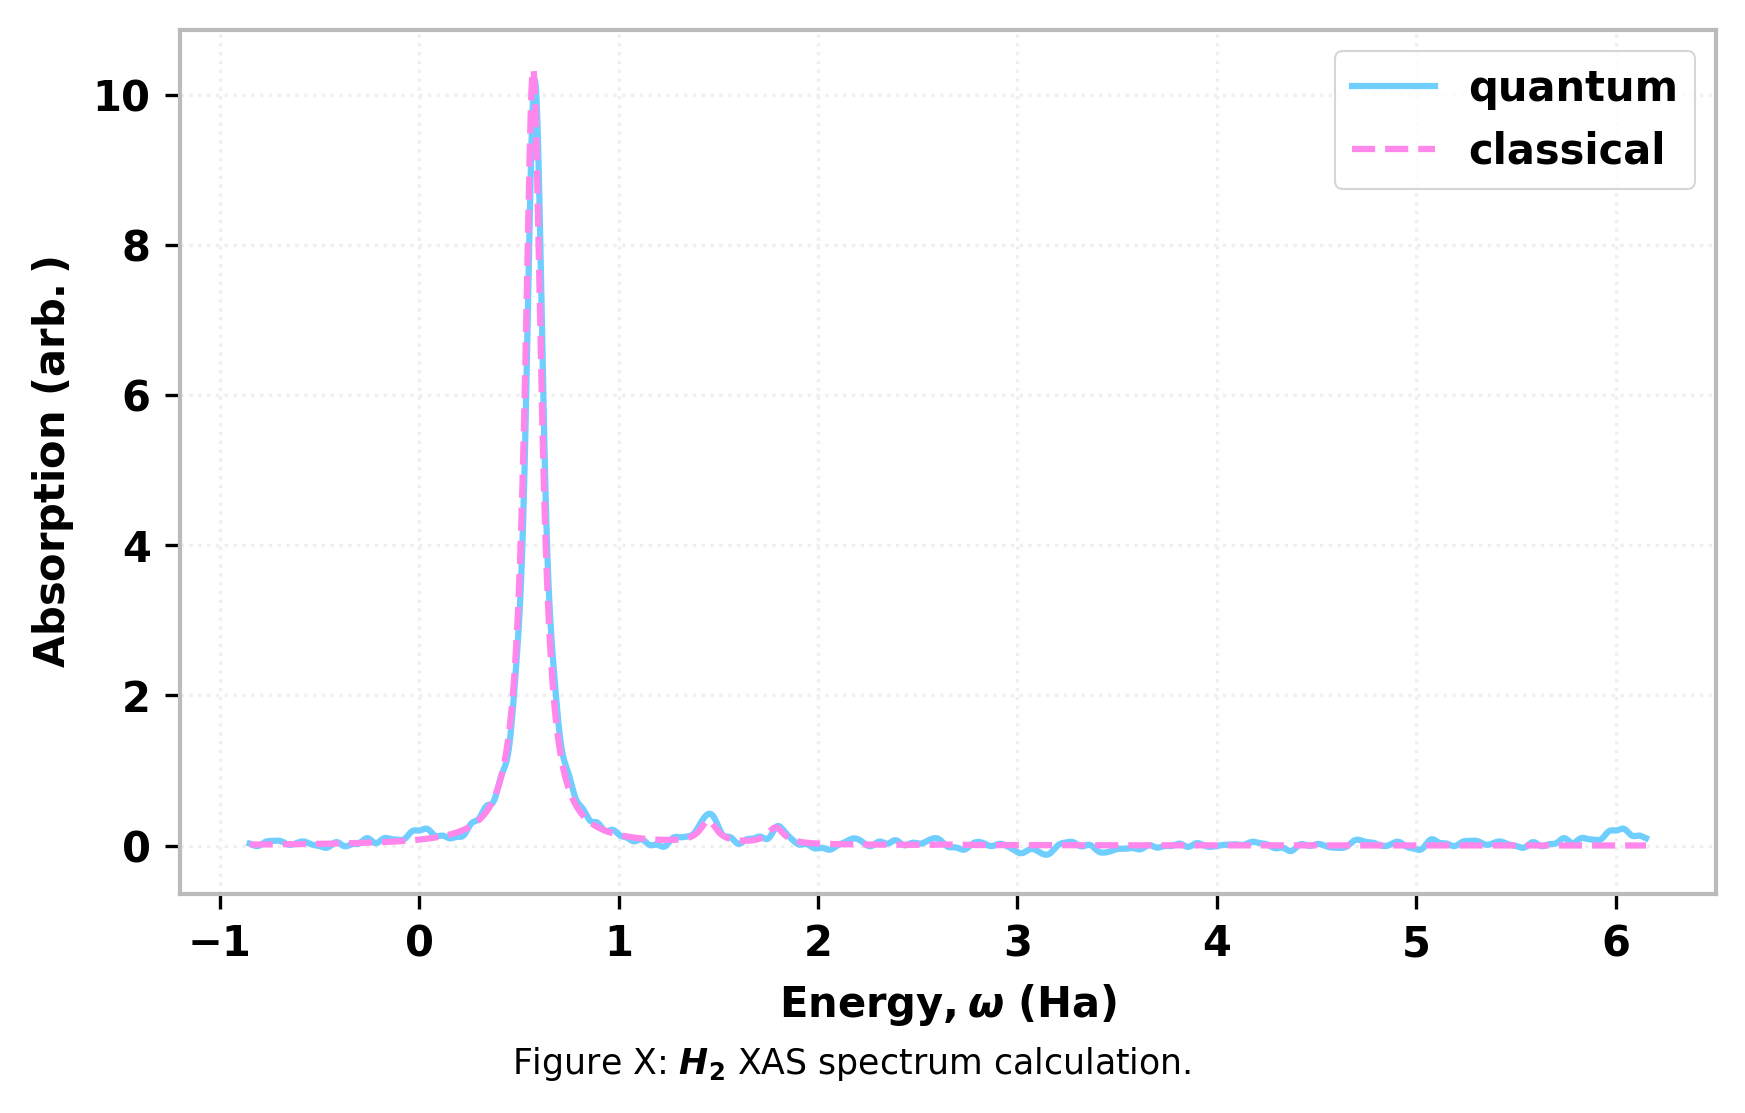

In [64]:
fig = plt.figure(figsize=(6.4, 4))
ax = fig.add_axes((0.15, 0.20, 0.80, 0.72))  # Make room for caption.

ax.plot(wgrid - E_i, spectrum, label='quantum')
ax.plot(wgrid - E_i, spectrum_classical, '--', label='classical')
ax.set_xlabel(r"$\mathrm{Energy}, \omega\ (\mathrm{Ha})$")
ax.set_ylabel(r"$\mathrm{Absorption\ (arb.)}$")
ax.legend()
fig.text(0.5, 0.05, r"Figure X: $H_2$ XAS spectrum calculation.",
        horizontalalignment="center", size="small", weight="normal")

plt.show()

### Core-valence separation approximation

For larger molecular instances, it may be valuable to restrict the terms coupled by the dipole operator to only include those of relevance for XAS, which are final states for where the *core* electrons are excited, i.e. there exists a hole in the core orbitals. These are known as core-excited states, and lie significantly above the valence-excited states in energy. Typically the frequency range is focused on a target atom in a molecular cluster, and also near a transition energy, such as targeting core $1s$ electrons.

Atomic species and oxidations states will determine the energy difference between states with different principle quantum numbers, and this difference will show as a peak in spectroscopy, known as the *absorption edge*. Focusing spectroscopy near this edge for $1s$ to $2p$ is called the $K$-edge, and in general X-ray absorption near-edge spectroscopy is known as XANES. By applying the core-valence separation approximation, we can force our calculation to stay in the XANES region.

![alt text](../_static/demonstration_assets/xas/core_valence.png){ width=50% }

Figure X: *Core-valence separation.* A much larger amount of energy is required to excite core electrons into valence orbitals compared to electrons already in low-lying valence orbitals. Since XAS targets core electrons, we can ignore valence-excitation matrix elements in our calculations.

### Further Optimizations

There are more optimizations for this algorithm that are included in the paper [#Fomichev2025]_ that we did not implemented in the above code. One could further optimize the compressed double-factorized Hamiltonian by applying a block-invarient symmetry shift (BLISS) [#Loaiza2023]_ to the Hamiltonian prior to compression. This is already detailed in the [demo on CDF Hamiltonians](https://pennylane.ai/qml/demos/tutorial_how_to_build_compressed_double_factorized_hamiltonians).

Another optimization is to use a randomized second-order Trotter formula for the time evolution. As discussed in Ref. [#Childs2019]_, deterministic product formulas have error that scales with the commutators of the Hamiltonian terms. One could instead use all permutations of the Hamiltonian terms, such that the commutator errors cancel. However, the average of all permutations is not unitary in general. To circumvent this, one can randomly choose a Hamiltonian term ordering, which can give a good approximation to the desired evolution.

More efficient methods of simulating XAS may be discovered in the near future, which could make this application even more viable as a use for early fault-tolerant quantum computers.

## Conclusion
In this tutorial, we have implemented a simplified version of the algorithm as presented in [#Fomichev2025]_. The algorithm represents a culmination of many optimizations for time-evolving an electronic Hamiltonian. We've also discussed how XAS is a promising candidate for early fault-tolerant quantum computers due to its low qubit overhead but high amount of correlations in the state space. 

*Acknowledgements*: The author thanks Stepan Fomichev and Pablo A. M. Casares for providing the code used in [#Fomichev2025]_, which was used as a basis for the simplified implementation demonstrated here.

## References

.. [#Fomichev2025]
    
Stepan Fomichev, Pablo A. M. Casares, Jay Soni, Utkarsh Azad, Alexander Kunitsa, Arne-Christian Voigt, Jonathan E. Mueller, Juan Miguel Arrazola, "Fast simulations of X-ray absorption spectroscopy for battery materials on a quantum computer". [arXiv preprint arXiv:2506.15784 (2025)](https://arxiv.org/abs/2506.15784).

.. [#Fomichev2024]

Stepan Fomichev, Kasra Hejazi, Ignacio Loaiza, Modjtaba Shokrian Zini, Alain Delgado, Arne-Christian Voigt, Jonathan E. Mueller, Juan Miguel Arrazola, "Simulating X-ray absorption spectroscopy of battery materials on a quantum computer". [arXiv preprint arXiv:2405.11015 (2024)](https://arxiv.org/abs/2405.11015).

.. [#Loaiza2023]

Ignacio Loaiza, Artur F Izmaylov, "Block-invariant symmetry shift: Preprocessing technique for second-quantized Hamiltonians to improve their decompositions to linear combination of unitaries". [J Chem Theory Comput. 19, 22, 8201–8209 (2023)](https://doi.org/10.1021/acs.jctc.3c00912).

.. [#Yen2021]

Tzu-Ching Yen and Artur F. Izmaylov, "Cartan subalgebra approach to efficient measurements of quantum observables", [PRX Quantum 2, 040320 (2021)](https://doi.org/10.1103/PRXQuantum.2.040320).

.. [#Cohn2021]

Jeffrey Cohn, Mario Motta, and Robert M. Parrish, "Quantum filter diagonalization with compressed double-factorized Hamiltonians". [PRX Quantum 2, 040352 (2021)](https://doi.org/10.1103/PRXQuantum.2.040352).

.. [#Childs2019]

Andrew M. Childs, Aaron Ostrander, Yuan Su, "Faster quantum simulation by randomization". [Quantum 3, 182 (2019)](https://doi.org/10.22331/q-2019-09-02-182).

.. [#Sherrill2005]

C. David Sherrill, ["Permutational symmetries of one- and two-electron integrals" (2005)](https://vergil.chemistry.gatech.edu/static/content/permsymm.pdf).

.. [#Thouless1960]

David J. Thouless, "Stability conditions and nuclear rotations in the Hartree-Fock theory". [Nuclear Physics, 21, 225-232 (1960)](https://doi.org/10.1016/0029-5582(60)90048-1).

## About the author